In [1]:
import numpy as np
from sympy.logic import SOPform, boolalg
from sympy import symbols, srepr, Not
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from BoolFunc import BoolFunc

In [4]:
funca = BoolFunc(param_type=3)

print(funca.get_params())
print(funca.get_SOP())
print(funca.get_D())

[array([[ 1,  1, -1],
       [-1, -1, -1],
       [ 1,  1,  0],
       [-1,  1, -1]]), array([[-1],
       [ 1],
       [-1],
       [ 0]]), array([[ 0, -1,  0,  0]]), 1]
0 | 1 | 2
4


In [6]:
freq_dict = {}
for i in tqdm(range(1000)):
    func = BoolFunc(n=3, param_type=3)
    count = 0
    SOP = func.get_SOP()
    if SOP == True or SOP == False or not isinstance(SOP, boolalg.Or):      # accounts for SOPs with just one literal for which equals() function seems to fail.
        for key in freq_dict:
            if func.get_SOP() == key:
                freq_dict[key][0] += 1
                count += 1
                break
    else:
        for key in freq_dict:
            if func.get_SOP().equals(key):
                freq_dict[key][0] += 1
                count += 1
                break
    if count == 0:
        freq_dict[SOP] = [1, func.get_D()]
        



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


In [8]:
P = []
D = []
for key in freq_dict:
    P.append(freq_dict[key][0]/1000)
    D.append(freq_dict[key][1])

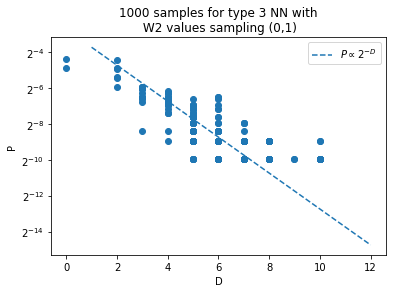

In [10]:
x = np.linspace(1,12, 100)
y = 0.15*2**(-x)

plt.scatter(D, P)
plt.plot(x,y, linestyle='--', label='$P\propto2^{-D}$')
plt.yscale('log', base=2)
plt.title('1000 samples for type 3 NN with\n W2 values sampling (0,1)')
plt.xlabel('D')
plt.ylabel('P')
plt.legend()
plt.savefig('P_vs_D_sampling_0_1_W2 _1000.png')